# Multivariate power curve monitoring
### Specialization project - Sondre Bungum

In [90]:
! pip install pyspark seaborn scikit-learn

In [91]:
#impot Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pyspark as spark # for big data analytics
from pyspark.sql import SparkSession
import seaborn as sb
from datetime import datetime
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from sklearn.neighbors import KNeighborsRegressor


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

spark_ses = SparkSession.builder.master("local").appName("Specialization_project").getOrCreate()
pd.options.display.float_format = '{:.2f}'.format

.\specialization-project-demo_code.ipynb
.\T1.csv


In [92]:
spark_df = spark_ses.read.csv("T1.csv", header=True, inferSchema=True)

print(spark_df.count())
pd_df = spark_df.toPandas()
start_date = pd_df['Date/Time'].iloc[0]
start_date = datetime.strptime(start_date, '%d %m %Y %H:%M')
end_date = datetime.strptime(pd_df['Date/Time'].iloc[-1], '%d %m %Y %H:%M')
increment = datetime.strptime(pd_df['Date/Time'].iloc[1], '%d %m %Y %H:%M') - datetime.strptime(pd_df['Date/Time'].iloc[0], '%d %m %Y %H:%M')


print(f'Data taken from date: [{start_date}] to [{end_date}], with increments of {increment}') 
print("\n Colums:")
print(spark_df.printSchema())

pd_df.head()

50530
Data taken from date: [2018-01-01 00:00:00] to [2018-12-31 23:50:00], with increments of 0:10:00

 Colums:
root
 |-- Date/Time: string (nullable = true)
 |-- LV ActivePower (kW): double (nullable = true)
 |-- Wind Speed (m/s): double (nullable = true)
 |-- Theoretical_Power_Curve (KWh): double (nullable = true)
 |-- Wind Direction (°): double (nullable = true)

None


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.05,5.31,416.33,259.99
1,01 01 2018 00:10,453.77,5.67,519.92,268.64
2,01 01 2018 00:20,306.38,5.22,390.90,272.56
3,01 01 2018 00:30,419.65,5.66,516.13,271.26
4,01 01 2018 00:40,380.65,5.58,491.70,265.67


### Plotting actual vs theoretical power curve, as well as Mean square error
A sample of the data set will be used and not all values will be plotted. This is to increase readability and reduce clustering.


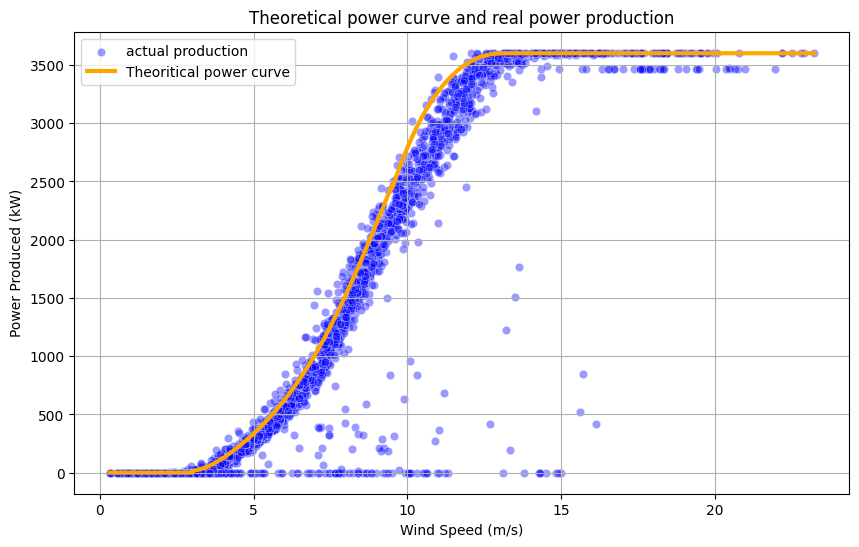

In [93]:
plt.figure(figsize=(10,6))
sample_df = spark_df.sample(fraction=0.05, seed=69).toPandas()

sb.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', color='blue', label='actual production', alpha=0.4, data=sample_df)
sb.lineplot(x='Wind Speed (m/s)', y='Theoretical_Power_Curve (KWh)', color='orange', linewidth = 3
            , label='Theoritical power curve', data=sample_df)

plt.title("Theoretical power curve and real power production")
plt.grid()
plt.ylabel('Power Produced (kW)')
plt.show()


Judging by the theoretical power curve, the cut-in point looks to be at around 3 m/s, and the rated power velocity around 13 m/s.\
The theoretical power curve looks to be relatively accurate at lower wind speeds, as well as for the rated region, which is understandable. \
It is lacking in the later non-rated region however, which means there is room for improvement.

There are many power production measurements of zero at speeds well above the theoretical cut-in point. As well as multiple points with lower power than expected.\
These points can be caused by gusts of wind which cause higher wind speeds to appear in the SCADA system, however is not enough to accelerate the turbine.

There are also several points of no powerproduction above the cut in point. These could be faults in the turbine, or periiods of service. Previous analys shows this most liekly during january and desember. As we are trying to find a steady state power curve, these values will be removed, for wind speed values above 4 m/s. Remaining outliers will be removed after correlation analysis

In [94]:
spark_df = spark_df.where(~((spark_df['Wind Speed (m/s)'] >= 4.) & (spark_df['LV ActivePower (kW)'] == 0)))

### Corrolation analysis
This will help map what available variables could be beneficial to include in regression model.\
To increase the amount of varriables to check, the month and, time of day is added to the dataset.\
The idea is that the different conditions of the seasons, as well the differences between night and day could have an impact on power production.

A Pearson correlation matrix will be will be used to analyze corrolations.

In [95]:
from pyspark.sql.functions import to_date, to_timestamp, hour, month


def get_hour(x):
    date = to_timestamp(x, 'dd MM yyyy HH:mm')
    return hour(date)

def get_month(x):
    date = to_date(x, 'dd MM yyyy HH:mm')
    return month(date)

spark_df = spark_df.withColumns({'Hour': get_hour(spark_df['Date/Time']), 'Month': get_month(spark_df['Date/Time'])})

spark_df.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- LV ActivePower (kW): double (nullable = true)
 |-- Wind Speed (m/s): double (nullable = true)
 |-- Theoretical_Power_Curve (KWh): double (nullable = true)
 |-- Wind Direction (°): double (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)



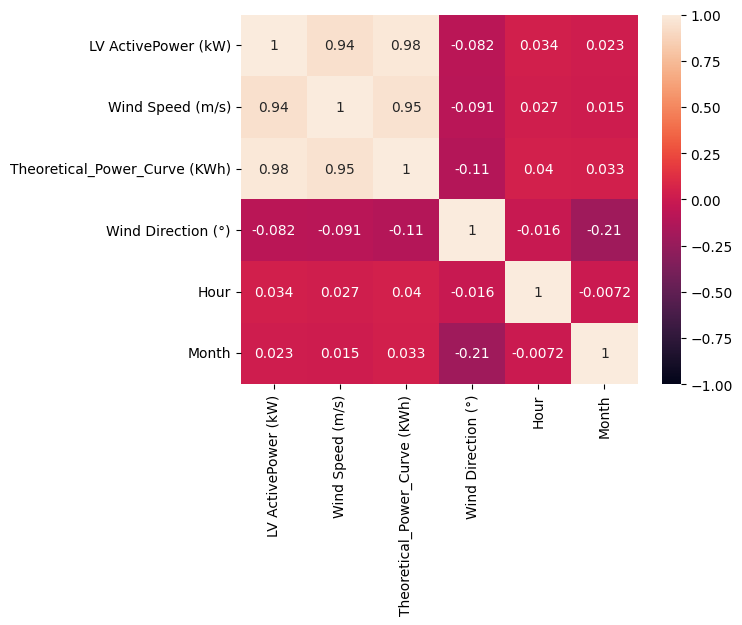

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Hour,Month
LV ActivePower (kW),1.00,0.94,0.98,-0.08,0.03,0.02
Wind Speed (m/s),0.94,1.00,0.95,-0.09,0.03,0.01
Theoretical_Power_Curve (KWh),0.98,0.95,1.00,-0.11,0.04,0.03
Wind Direction (°),-0.08,-0.09,-0.11,1.00,-0.02,-0.21
Hour,0.03,0.03,0.04,-0.02,1.00,-0.01
Month,0.02,0.01,0.03,-0.21,-0.01,1.00


In [96]:
corrolation_sample = spark_df.sample(fraction=0.1, seed=24).toPandas()
corrolation_matrix = corrolation_sample.corr(method="pearson", numeric_only = True)

ax = sb.heatmap(corrolation_matrix, vmin = -1, vmax = 1, annot = True)
plt.show()
corrolation_matrix


This shows a strong positive corrolation between power and wind speed, which is to be expected.\
Power production also a minor negative corrolation with wind direction with wind direction, which will be further explored using the K-NN model.\
Hour and Month unfortunalty show little to no correlation with the wind speed and active power, however does have corrolation with the wind direction.

### Defining feature vectors for the test cases.
Three degrees of vectorsets will be tested

In [97]:
#defining the label and features for the set. Label is the active power produced.
spark_df = spark_df.withColumn('label', spark_df['LV ActivePower (kW)'])

basic_feature_columns = ['Wind Speed (m/s)']
intermediate_feature_columns = ['Wind Speed (m/s)', 'Wind Direction (°)']
full_feature_columns = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Hour', 'Month']

basic_feature_vector_assembler = VectorAssembler(inputCols=basic_feature_columns, outputCol='basic_features')
intermediate_feature_vector_assembler = VectorAssembler(inputCols=intermediate_feature_columns, outputCol='intermediate_features')
full_feature_vector_assembler = VectorAssembler(inputCols=full_feature_columns, outputCol='full_features')

fv_df = basic_feature_vector_assembler.transform(spark_df)
fv_df = intermediate_feature_vector_assembler.transform(fv_df)
fv_df = full_feature_vector_assembler.transform(fv_df)
fv_df = fv_df.select('label', 'basic_features', 'intermediate_features', 'full_features', 'Wind Speed (m/s)')
fv_df.show(5)

+----------------+------------------+---------------------+--------------------+----------------+
|           label|    basic_features|intermediate_features|       full_features|Wind Speed (m/s)|
+----------------+------------------+---------------------+--------------------+----------------+
|380.047790527343|[5.31133604049682]| [5.31133604049682...|[5.31133604049682...|5.31133604049682|
| 453.76919555664|[5.67216682434082]| [5.67216682434082...|[5.67216682434082...|5.67216682434082|
|306.376586914062|[5.21603679656982]| [5.21603679656982...|[5.21603679656982...|5.21603679656982|
|419.645904541015|[5.65967416763305]| [5.65967416763305...|[5.65967416763305...|5.65967416763305|
|380.650695800781|[5.57794094085693]| [5.57794094085693...|[5.57794094085693...|5.57794094085693|
+----------------+------------------+---------------------+--------------------+----------------+
only showing top 5 rows



### Defining the training set and test set.
The traning : test ration will be 80:20, as this is concidered good practice in ml.

In [98]:
splits = fv_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  39038
Test dataset :  9705


## Regression
### K-Nearest Neighbourhood


In [99]:
x_basic_train = train_df.toPandas()['basic_features'].transform(lambda x: x.toArray()).to_numpy().reshape(-1, 1)
x_inter_train = np.stack(train_df.toPandas()['intermediate_features'].transform(lambda x: x.toArray()).to_numpy())
x_full_train = np.stack(train_df.toPandas()['full_features'].transform(lambda x: x.toArray()).to_numpy())

y_train = train_df.toPandas()['label'].to_numpy()

In [100]:
x_basic_test = test_df.toPandas()['basic_features'].transform(lambda x: x.toArray()).to_numpy().reshape(-1, 1)
x_inter_test = np.stack(test_df.toPandas()['intermediate_features'].transform(lambda x: x.toArray()).to_numpy())
x_full_test = np.stack(test_df.toPandas()['full_features'].transform(lambda x: x.toArray()).to_numpy())

y_test = test_df.toPandas()['label'].to_numpy()

In [101]:
y_test

array([-1.07713103e+00, -5.81133723e-01, -4.88667488e-01, ...,
        3.60456299e+03,  3.60466504e+03,  3.60575806e+03])

In [102]:
k = 8

knn_basic = KNeighborsRegressor(n_neighbors=k)
knn_intermediate = KNeighborsRegressor(n_neighbors=k)
knn_full = KNeighborsRegressor(n_neighbors=k)

paired_list = zip([knn_basic, knn_intermediate, knn_full], [x_basic_train, x_inter_train, x_full_train])
for knn, train_data in paired_list:
    knn.fit(train_data, y_train)

In [103]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

paired_list = zip([knn_basic, knn_intermediate, knn_full], [x_basic_test, x_inter_test, x_full_test], ['Basic', 'Intermediate', 'Full'])

knn_error_values = []

for knn, x_test, name in paired_list:
    y_pred = knn.predict(x_test)
    error = calculate_rmse(y_test, y_pred)
    knn_error_values.append(error)


### Gradient boosting

In [104]:
! pip install xgboost pyarrow


[notice] A new release of pip is available: 23.1.1 -> 23.3.1
[notice] To update, run: C:\Users\Sondre\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [105]:
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor
import pyarrow

gbm_basic = GBTRegressor(featuresCol='basic_features', labelCol='label', predictionCol='basic_prediction')
gbm_intermediate = GBTRegressor(featuresCol='intermediate_features', labelCol='label', predictionCol='intermediate_prediction')
gbm_full = GBTRegressor(featuresCol='full_features', labelCol='label', predictionCol='full_prediction')

gbm_basic = SparkXGBRegressor(features_col='basic_features', label_col='label', prediction_col='basic_prediction')
gbm_intermediate = SparkXGBRegressor(features_col='intermediate_features', label_col='label', prediction_col='intermediate_prediction')
gbm_full = SparkXGBRegressor(features_col='full_features', label_col='label', prediction_col='full_prediction')

gbm_model_basic = gbm_basic.fit(train_df)
gbm_model_intermediate = gbm_intermediate.fit(train_df)
gbm_model_full = gbm_full.fit(train_df)

y_pred = gbm_model_basic.transform(test_df)
y_pred = gbm_model_intermediate.transform(y_pred)
y_pred = gbm_model_full.transform(y_pred) 


2023-12-11 00:08:15,273 INFO XGBoost-PySpark: _fit Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-12-11 00:08:19,014 INFO XGBoost-PySpark: _fit Finished xgboost training!
2023-12-11 00:08:19,090 INFO XGBoost-PySpark: _fit Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-12-11 00:08:22,865 INFO XGBoost-PySpark: _fit Finished xgboost training!
2023-12-11 00:08:22,950 INFO XGBoost-PySpark: _fit Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatri

In [112]:
from pyspark.ml.evaluation import RegressionEvaluator
regression_evaluator_basic = RegressionEvaluator(predictionCol = 'basic_prediction')
regression_evaluator_intermediate = RegressionEvaluator(predictionCol = 'intermediate_prediction')
regression_evaluator_full = RegressionEvaluator(predictionCol = 'full_prediction')
regression_evaluator_theoretical = RegressionEvaluator(labelCol='LV ActivePower (kW)', predictionCol = 'Theoretical_Power_Curve (KWh)')

eval_name_pairing = zip([regression_evaluator_basic, regression_evaluator_intermediate, regression_evaluator_full], ['basic_gbt', 'intermediate_gbt', 'full_gbt'])
gbt_error_values = []

for evaluator, name in eval_name_pairing:
    rmse = evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'})
    gbt_error_values.append(rmse)
    print('RMSE', name,      ': ', rmse)

theoretical_rmse = regression_evaluator_theoretical.evaluate(spark_df, {evaluator.metricName: 'rmse'})
print('RMSE theoretical     : ', theoretical_rmse)

RMSE basic_gbt :  244.6147084408367
RMSE intermediate_gbt :  240.61676948851377
RMSE full_gbt :  159.18729543160117
RMSE theoretical     :  304.6003484354531


### Plotting the results

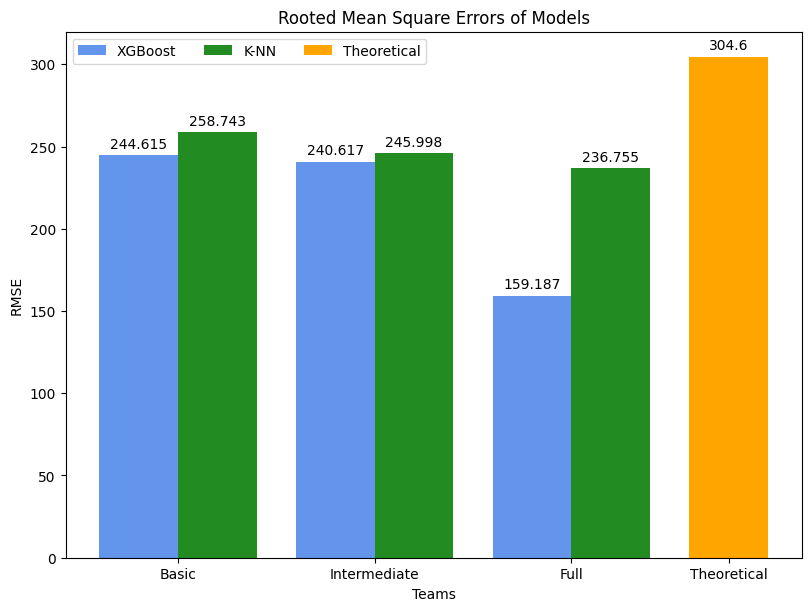

In [113]:
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(6)
fig.set_figwidth(8)

x = np.arange(3)

width = 0.4
offset = width/2
  
# plot data in grouped manner of bar type 

gbt_bar = ax.bar(x-offset, gbt_error_values, width, color='cornflowerblue', label="XGBoost")
knn_bar = ax.bar(x+offset, knn_error_values, width, color='forestgreen', label="K-NN") 
theo_bar = ax.bar(3-offset, theoretical_rmse, width=width, color='orange', label="Theoretical")
ax.bar_label(gbt_bar, padding=3)
ax.bar_label(knn_bar, padding=3)
ax.bar_label(theo_bar, padding=3)


plt.xticks([0, 1, 2, 3-offset], ['Basic', 'Intermediate', 'Full', 'Theoretical']) 
plt.xlabel("Teams") 
plt.ylabel("RMSE") 
plt.legend(loc='upper left', ncols=3) 
plt.title('Rooted Mean Square Errors of Models')

plt.show()


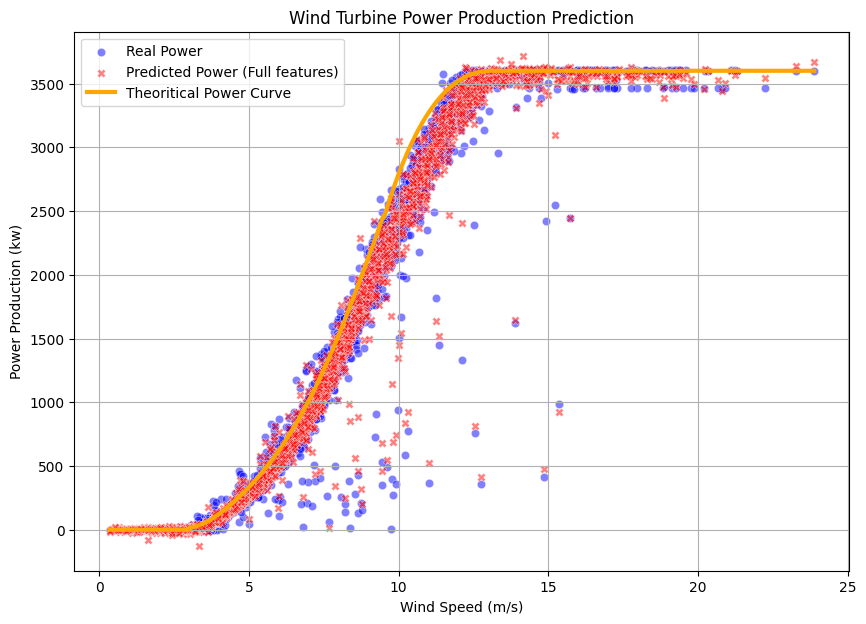

In [108]:
#plot code (mostly) from https://www.kaggle.com/code/akdagmelih/wind-turbine-power-prediction-gbtregressor-pyspark
sample_df = spark_df.sample(fraction=0.05, seed=69).toPandas()

eva_df = spark_ses.createDataFrame(sample_df)
eva_df = eva_df.withColumn('label', eva_df['Lv Activepower (kW)'])

eva_vf_df = full_feature_vector_assembler.transform(eva_df)

# Combining features and label column
eva_vf_df = eva_vf_df.select('full_features', 'label')

# Using ML model to predict
sample_pred = gbm_model_full.transform(eva_vf_df)
sample_pred_df = sample_pred.select('label','full_prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']], sample_pred_df]
sample_data = pd.concat(frames, axis=1)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sb.scatterplot(x='Wind Speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data, color='blue')
sb.scatterplot(x='Wind Speed (m/s)', y='full_prediction', alpha=0.5, label='Predicted Power (Full features)', marker='X', data=sample_data, color='red')
sb.lineplot(x='Wind Speed (m/s)', y='Theoretical_Power_Curve (KWh)', color='orange', label='Theoritical Power Curve', data=sample_data, linewidth = 3)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend()
plt.grid()
plt.show()

### Seeing which months the poweroutput differs from the theoretical graph.

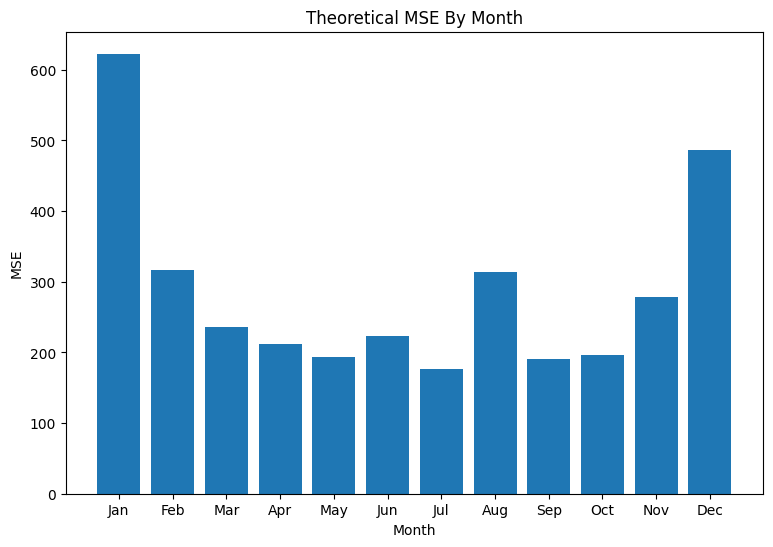

In [109]:
theoretical_mse_by_month = []
for i in range (1, 13):
    mothly_mse = regression_evaluator_theoretical.evaluate(spark_df.filter(spark_df['Month'] == i), {evaluator.metricName: 'mse'})
    theoretical_mse_by_month.append(mothly_mse)

months_list = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(9,6))
plt.bar(months_list, theoretical_mse_by_month)
plt.title('Theoretical MSE By Month')
plt.xlabel('Month')
plt.ylabel('MSE')
plt.show()

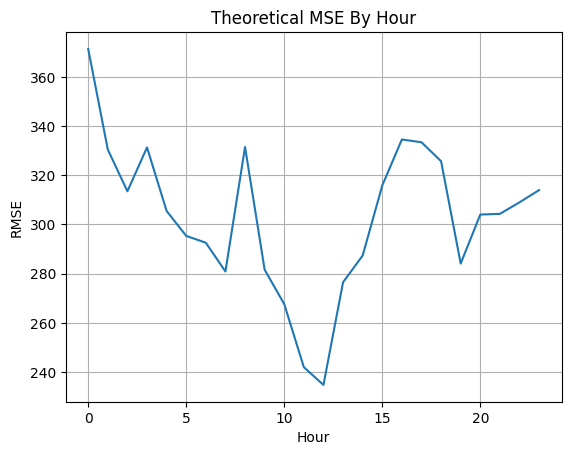

In [110]:
theoretical_mse_by_hour = []
for i in range (0, 24):
    hourly_mse = regression_evaluator_theoretical.evaluate(spark_df.filter(spark_df['Hour'] == i), {evaluator.metricName: 'mse'})
    theoretical_mse_by_hour.append(hourly_mse)

hours_list = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"]



plt.plot(np.arange(24), theoretical_mse_by_hour)
plt.title('Theoretical MSE By Hour')
plt.xlabel('Hour')
plt.ylabel('RMSE')
plt.grid()
plt.show()

Overfitting in term of months, because the whole data set is within one year, but future data will not be.


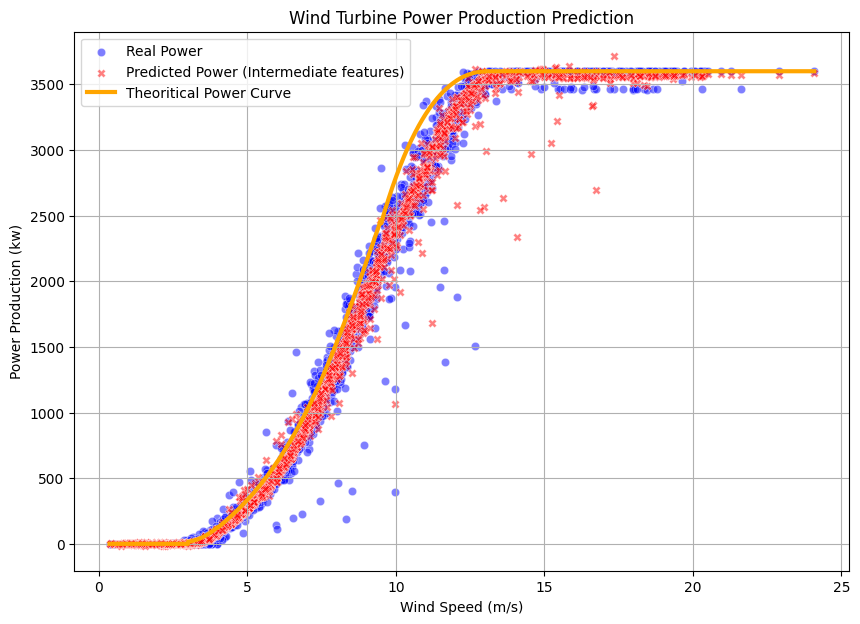

In [111]:
#Plot of interbmediate model and data outside january and desember.



#plot code (mostly) from https://www.kaggle.com/code/akdagmelih/wind-turbine-power-prediction-gbtregressor-pyspark
sample_df = spark_df.filter(~((spark_df['Month']==1) | (spark_df['Month'] == 12))).sample(fraction=0.05, seed=69).toPandas()

eva_df = spark_ses.createDataFrame(sample_df)
eva_df = eva_df.withColumn('label', eva_df['Lv Activepower (kW)'])

eva_vf_df = intermediate_feature_vector_assembler.transform(eva_df)

# Combining features and label column
eva_vf_df = eva_vf_df.select('intermediate_features', 'label')

# Using ML model to predict
sample_pred = gbm_model_intermediate.transform(eva_vf_df)
sample_pred_df = sample_pred.select('label','intermediate_prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']], sample_pred_df]
sample_data = pd.concat(frames, axis=1)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sb.scatterplot(x='Wind Speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data, color='blue')
sb.scatterplot(x='Wind Speed (m/s)', y='intermediate_prediction', label='Predicted Power (Intermediate features)', data=sample_data, color='red', marker='X', alpha=0.5)
sb.lineplot(x='Wind Speed (m/s)', y='Theoretical_Power_Curve (KWh)', color='orange', label='Theoritical Power Curve', data=sample_data, linewidth = 3)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend()
plt.grid()
plt.show()